In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
parameters=pd.read_csv('slurm.conf_params.csv')
parameters

,sim_id,fairshare,age,jobsize,bfwindow
0,0,100,100,100,2880
1,1,100,100,100,4320
2,2,100,100,100,5760
3,3,100,100,1000,2880
4,4,100,100,1000,4320
...,...,...,...,...,...
76,76,10000,10000,1000,4320
77,77,10000,10000,1000,5760
78,78,10000,10000,10000,2880
79,79,10000,10000,10000,4320


In [3]:
jobs = {}
for i in range(81): 
    jobs[i] = pd.read_csv(f'jobs-logs/job{i:02d}', sep='|')

In [4]:
for i in range(81):
    unknown_end = jobs[i]['End'] == 'Unknown'

    # Get Start times for those rows
    start_times_unknown_end = pd.to_datetime(jobs[i].loc[unknown_end, 'Start'])

    # Get elapsed times and convert to timedelta
    elapsed_unknown_end = pd.to_timedelta(jobs[i].loc[unknown_end, 'ElapsedRaw'], unit='s')

    # Calculate End times and update
    jobs[i].loc[unknown_end, 'End'] = start_times_unknown_end + elapsed_unknown_end

In [5]:
for i in range(81):
    #let's convert the start, end, submit to datetime
    jobs[i]['Start'] = pd.to_datetime(jobs[i]['Start'])
    jobs[i]['End'] = pd.to_datetime(jobs[i]['End'])
    jobs[i]['Submit'] = pd.to_datetime(jobs[i]['Submit'])

/var/folders/4l/38df5lt94y735sny607xh5rh0000gn/T/ipykernel_28076/4083314372.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  jobs[i]['End'] = pd.to_datetime(jobs[i]['End'])
/var/folders/4l/38df5lt94y735sny607xh5rh0000gn/T/ipykernel_28076/4083314372.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  jobs[i]['End'] = pd.to_datetime(jobs[i]['End'])
/var/folders/4l/38df5lt94y735sny607xh5rh0000gn/T/ipykernel_28076/4083314372.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  jobs[i]['End'] = pd.to_datetime(jobs[i]['End'])
/var/folders/4l/38df5lt94y735sny607xh5rh0000gn/T/ipy

### Job Submission Times

In [6]:
for i in range(81):
    #let's calculate wait time
    jobs[i]['wait_time'] = (jobs[i]['Start'] - jobs[i]['Submit']).dt.total_seconds()

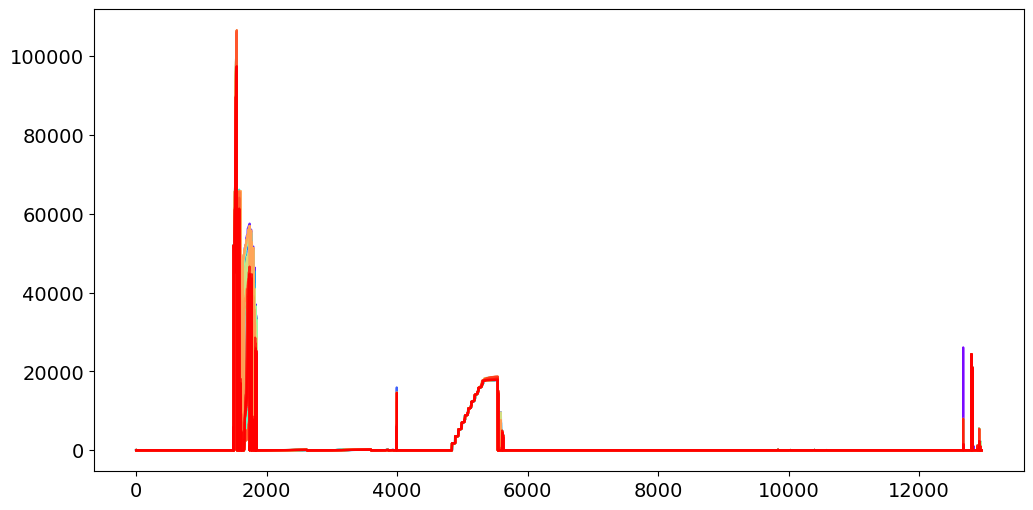

In [7]:
plt.rcParams['font.size'] = 14
f,ax=plt.subplots(1,1,figsize=(12,6),sharey=True)

colors = plt.cm.rainbow(np.linspace(0, 1, 81))
for i in range(81):
    ax.plot(jobs[i]['wait_time'],color=colors[i])
    #plt.plot(jobs[i]['wait_time'][4000:6000],color=colors[i])
#plt.plot(jobs[27]['wait_time'],color=colors[i])
#plt.xlim([1000,2000])
plt.show()

In [8]:
for i in range(81):
    print(f'at i={i} the avg wait time = {jobs[i]['wait_time'].mean()}')

at i=0 the avg wait time = 1557.9777812066038
at i=1 the avg wait time = 1552.1906341613949
at i=2 the avg wait time = 1564.5521524456103
at i=3 the avg wait time = 1625.0856349328808
at i=4 the avg wait time = 1706.0249961425707
at i=5 the avg wait time = 1624.6772874556395
at i=6 the avg wait time = 1618.8632927017436
at i=7 the avg wait time = 1635.6000617188706
at i=8 the avg wait time = 1649.3802653911434
at i=9 the avg wait time = 1489.197963277272
at i=10 the avg wait time = 1458.8214010183613
at i=11 the avg wait time = 1489.866918685388
at i=12 the avg wait time = 1549.0314766239778
at i=13 the avg wait time = 1554.1135627218023
at i=14 the avg wait time = 1518.0509952167874
at i=15 the avg wait time = 1687.3264156765931
at i=16 the avg wait time = 1618.2041351643265
at i=17 the avg wait time = 1682.1539885820089
at i=18 the avg wait time = 1494.2430180527697
at i=19 the avg wait time = 1496.5351026076223
at i=20 the avg wait time = 1493.7938589723808
at i=21 the avg wait time

/var/folders/4l/38df5lt94y735sny607xh5rh0000gn/T/ipykernel_28076/2687541794.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14,loc='upper right')


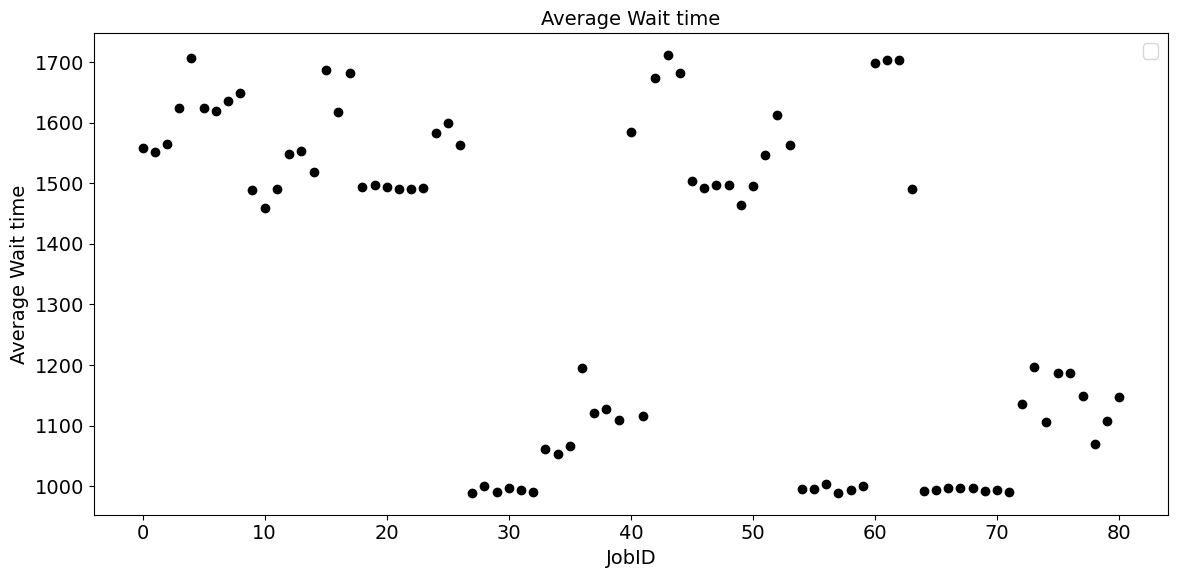

In [9]:
plt.rcParams['font.size'] = 14
f,ax=plt.subplots(1,1,figsize=(12,6),sharey=True)

for i in range(81):
    plt.plot(i,jobs[i]['wait_time'].mean(),'o',color='black')

ax.set_title('Average Wait time', fontsize=14)
ax.set_xlabel('JobID', fontsize=14)
ax.set_ylabel('Average Wait time', fontsize=14)
plt.legend(fontsize=14,loc='upper right')
plt.tight_layout()
plt.show()

### Number of Processors used

In [10]:
jobs_ncpu_used={}
jobs_time_stamps={}

for jobid in range(81):
    print(f"processing job {jobid}")
    #
    start_time=jobs[jobid]["Start"]
    end_time=jobs[jobid]["End"]
    all_time_stamps=pd.concat([start_time,end_time]).sort_values().unique().tolist()
    #
    jobs_ncpu_used[jobid]=[]
    jobs_time_stamps[jobid]=all_time_stamps
    for i in range(len(all_time_stamps)):
        current_time=all_time_stamps[i]
        jobs_ncpu_used[jobid].append( jobs[jobid].loc[(jobs[jobid]["Start"]<=current_time) & (jobs[jobid]["End"]>current_time) ,"ReqCPUS"].sum() )

processing job 0
processing job 1
processing job 2
processing job 3
processing job 4
processing job 5
processing job 6
processing job 7
processing job 8
processing job 9
processing job 10
processing job 11
processing job 12
processing job 13
processing job 14
processing job 15
processing job 16
processing job 17
processing job 18
processing job 19
processing job 20
processing job 21
processing job 22
processing job 23
processing job 24
processing job 25
processing job 26
processing job 27
processing job 28
processing job 29
processing job 30
processing job 31
processing job 32
processing job 33
processing job 34
processing job 35
processing job 36
processing job 37
processing job 38
processing job 39
processing job 40
processing job 41
processing job 42
processing job 43
processing job 44
processing job 45
processing job 46
processing job 47
processing job 48
processing job 49
processing job 50
processing job 51
processing job 52
processing job 53
processing job 54
processing job 55
pr

In [11]:
jobs_average_cpu_usage={}

def calculate_time_weighted_average(timestamps, values):
    """
    Calculate time-weighted average for time series data
    """
    # Convert timestamps to numeric values (seconds since first timestamp)
    if isinstance(timestamps[0], pd.Timestamp):
        numeric_times = [(t - timestamps[0]).total_seconds() for t in timestamps]
    else:
        numeric_times = timestamps
    
    # Calculate area under curve using trapezoidal rule
    area = np.trapz(values, numeric_times)
    
    # Divide by total time span
    total_time = numeric_times[-1] - numeric_times[0]
    
    return area / total_time if total_time > 0 else np.mean(values)

# Example usage for your CPU data:
for jobid in range(81):
    jobs_average_cpu_usage[jobid] = calculate_time_weighted_average(
        jobs_time_stamps[jobid], 
        jobs_ncpu_used[jobid]
    )

/var/folders/4l/38df5lt94y735sny607xh5rh0000gn/T/ipykernel_28076/2024005916.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(values, numeric_times)


/var/folders/4l/38df5lt94y735sny607xh5rh0000gn/T/ipykernel_28076/2065262219.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14,loc='upper right')


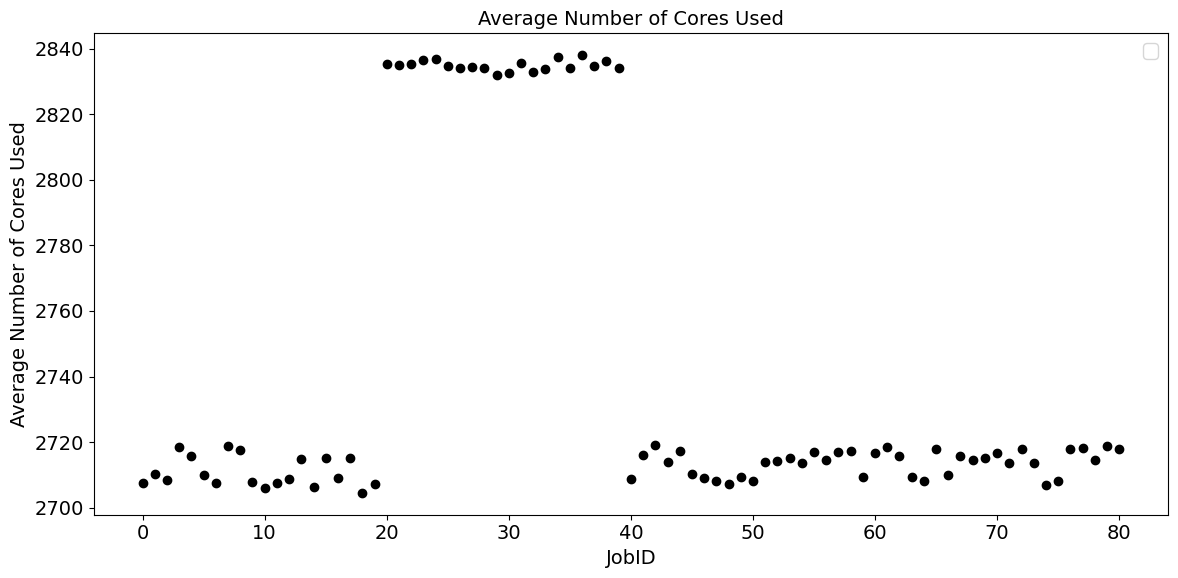

In [12]:
plt.rcParams['font.size'] = 14
f,ax=plt.subplots(1,1,figsize=(12,6),sharey=True)

for i in range(81):
    plt.plot(i,jobs_average_cpu_usage[i],'o',color='black')

ax.set_title('Average Number of Cores Used', fontsize=14)
ax.set_xlabel('JobID', fontsize=14)
ax.set_ylabel('Average Number of Cores Used', fontsize=14)
plt.legend(fontsize=14,loc='upper right')
plt.tight_layout()
plt.show()

/var/folders/4l/38df5lt94y735sny607xh5rh0000gn/T/ipykernel_28076/2802572803.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14,loc='upper right')


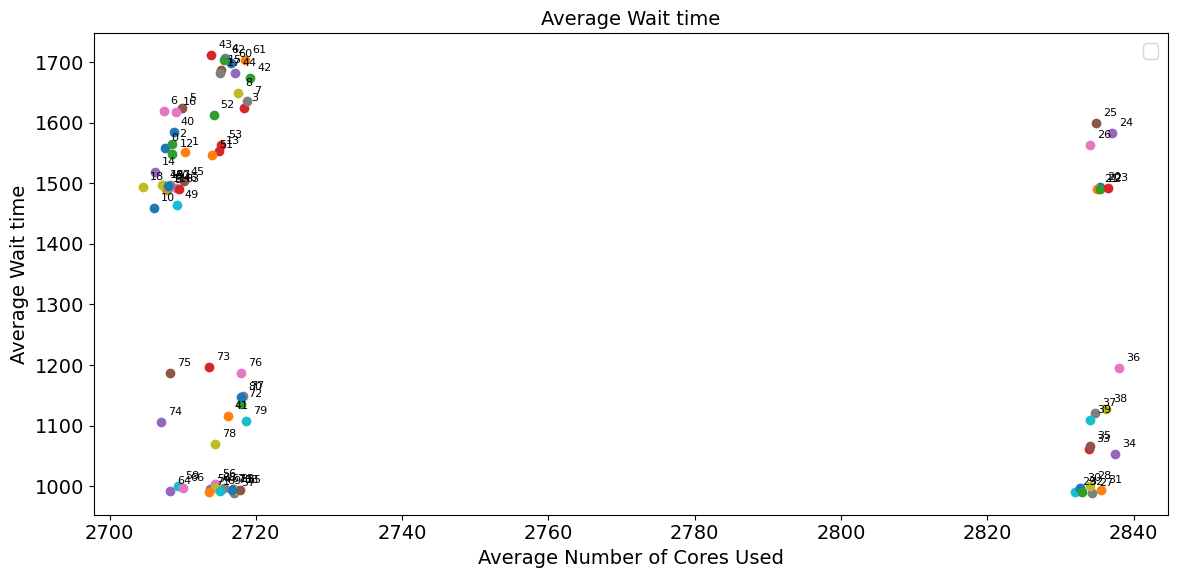

In [13]:
#Multi-objective optimization
plt.rcParams['font.size'] = 14
f,ax=plt.subplots(1,1,figsize=(12,6),sharey=True)

for jobid in range(81):
    plt.plot(jobs_average_cpu_usage[jobid],jobs[jobid]['wait_time'].mean(),'o')
    plt.annotate(str(jobid), (jobs_average_cpu_usage[jobid], jobs[jobid]['wait_time'].mean()), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_title('Average Wait time', fontsize=14)
ax.set_xlabel('Average Number of Cores Used', fontsize=14)
ax.set_ylabel('Average Wait time', fontsize=14)
plt.legend(fontsize=14,loc='upper right')
plt.tight_layout()
plt.show()

/var/folders/4l/38df5lt94y735sny607xh5rh0000gn/T/ipykernel_28076/169606331.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14,loc='upper right')


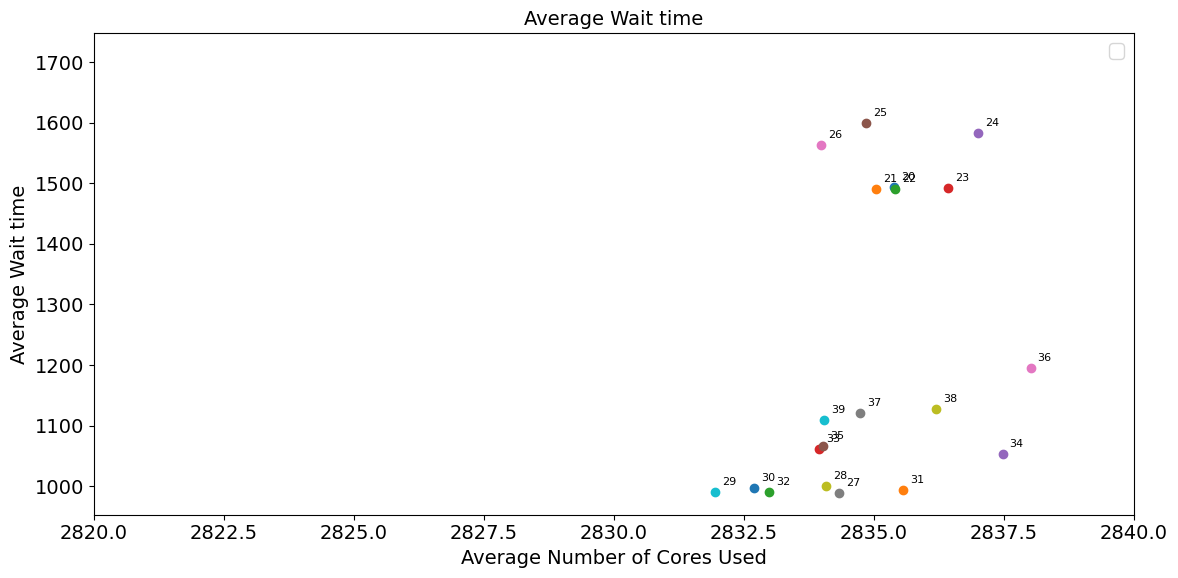

In [14]:
#Multi-objective optimization
plt.rcParams['font.size'] = 14
f,ax=plt.subplots(1,1,figsize=(12,6),sharey=True)

for jobid in range(81):
    plt.plot(jobs_average_cpu_usage[jobid],jobs[jobid]['wait_time'].mean(),'o')
    plt.annotate(str(jobid), (jobs_average_cpu_usage[jobid], jobs[jobid]['wait_time'].mean()), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_title('Average Wait time', fontsize=14)
ax.set_xlabel('Average Number of Cores Used', fontsize=14)
ax.set_ylabel('Average Wait time', fontsize=14)
ax.set_xlim(2820,2840)
plt.legend(fontsize=14,loc='upper right')
plt.tight_layout()
plt.show()

### Total Time

/var/folders/4l/38df5lt94y735sny607xh5rh0000gn/T/ipykernel_28076/3015721980.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14,loc='upper right')


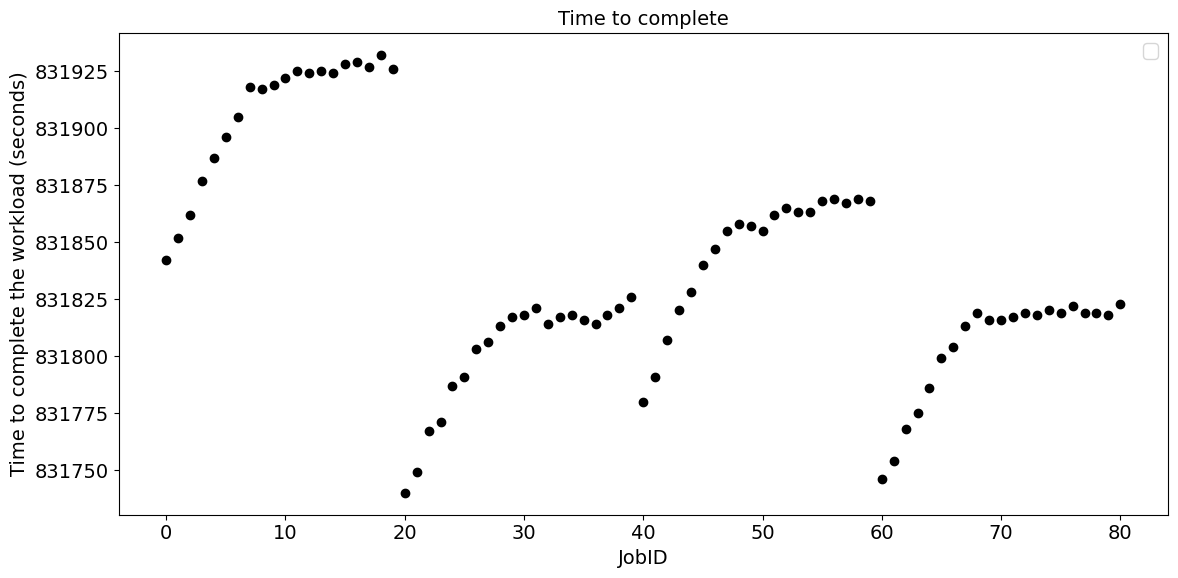

In [15]:
plt.rcParams['font.size'] = 14
f,ax=plt.subplots(1,1,figsize=(12,6),sharey=True)

njobs=len(jobs[0]['End'])
jobs_time_to_complete=[]
for i in range(81):
    jobs_time_to_complete.append((jobs[i]['End'][njobs-1]-jobs[i]['Start'][0]).total_seconds())

plt.plot(jobs_time_to_complete,'o',color='black')

ax.set_title('Time to complete', fontsize=14)
ax.set_xlabel('JobID', fontsize=14)
ax.set_ylabel('Time to complete the workload (seconds)', fontsize=14)
plt.legend(fontsize=14,loc='upper right')
plt.tight_layout()
plt.show()

/var/folders/4l/38df5lt94y735sny607xh5rh0000gn/T/ipykernel_28076/3919303269.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14,loc='upper right')


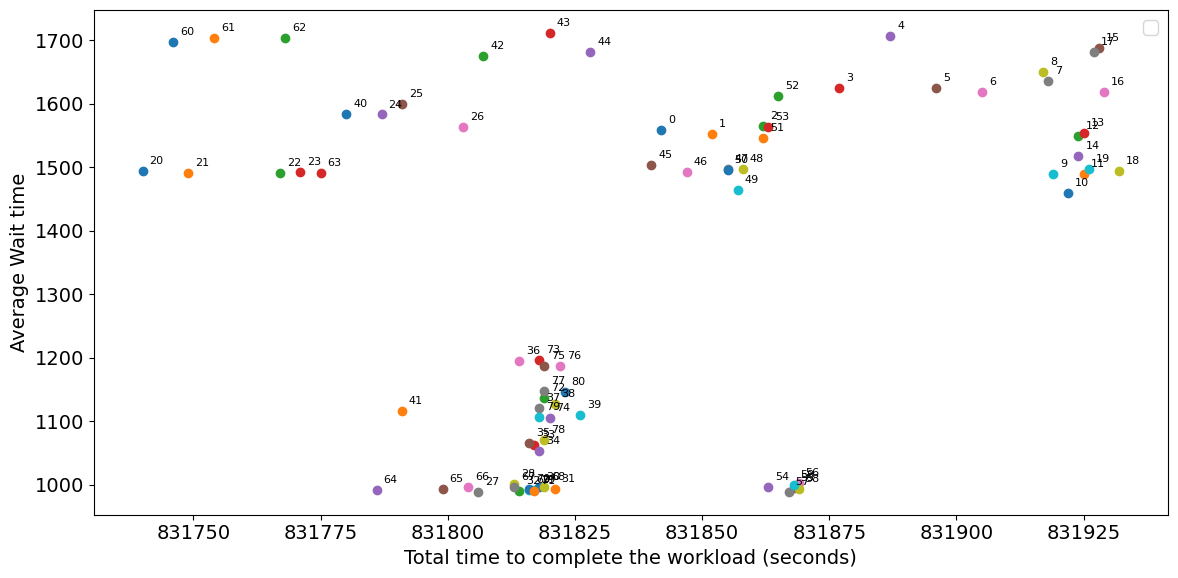

In [16]:
#Multi-objective optimization
plt.rcParams['font.size'] = 14
f,ax=plt.subplots(1,1,figsize=(12,6),sharey=True)

for jobid in range(81):
    plt.plot(jobs_time_to_complete[jobid],jobs[jobid]['wait_time'].mean(),'o')
    plt.annotate(str(jobid), (jobs_time_to_complete[jobid], jobs[jobid]['wait_time'].mean()), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_xlabel('Total time to complete the workload (seconds)', fontsize=14)
ax.set_ylabel('Average Wait time', fontsize=14)
plt.legend(fontsize=14,loc='upper right')
plt.tight_layout()
plt.show()